In [1]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import pandas as pd
import time

from mlp import classification_accuracy, MLP

## Data Loading and cleaning

In [2]:
with h5py.File('../Inputs/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('../Inputs/train_label.h5', 'r') as H:
    label = np.copy(H['label'])

### Data Exploration

In [3]:
data.shape

(60000, 128)

In [4]:
print('Set of labels are {} and shape is {}'.format(set(label), label.shape))

Set of labels are {0, 1, 2, 3, 4, 5, 6, 7, 8, 9} and shape is (60000,)


In [5]:
# Any missing values?
np.where(np.isnan(data))

(array([], dtype=int64), array([], dtype=int64))

In [27]:
label_series = pd.Series(label)
label_series.value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64

### Shuffling

In [6]:
def shuffle(x,y):
        """
        shuffles given input and target variables of same first axis shape
        :returns x,y: shuffled input and target
        """
        idxs = list(range(x.shape[0])) 
        np.random.shuffle(idxs)
        return x[idxs], y[idxs]

In [7]:
data_shuffled, label_shuffled = shuffle(data, label)

### Split into training and validation

In [8]:
# train
x_train = data_shuffled[0:54000,:]
y_train = label_shuffled[0:54000]
# val
x_val = data_shuffled[54000:60000,:]
y_val = label_shuffled[54000:60000]

### Feature Engineering

In [9]:
# Optional: Standardise both train and val
mu = x_train.mean()
sigma = x_train.std()

x_train = (x_train - mu)/sigma
x_val = (x_val - mu)/sigma

In [10]:
def _one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)

In [11]:
y_train = _one_hot(y_train, 10)
y_val = _one_hot(y_val, 10)

In [12]:
print(x_train.shape, y_train.shape)

(54000, 128) (54000, 10)


## Modelling

### Baseline model - Training

In [17]:
## From mlp.py
baseline = MLP(layers = [128,64,32,16,10],
         activation = [None,'tanh','tanh','relu','softmax'],
         batch_norm= [None, False, False, False, False], 
         dropouts= [None, 0, 0, 0, 0])

In [18]:
print(baseline.layers[0].W.shape, baseline.layers[0].b.shape)

(128, 64) (64,)


In [19]:
classification_accuracy(baseline.forward(x_train[:5000]), y_train[:5000])

0.1798

In [20]:
stime = time.time()

base_loss, base_train_acc, base_val_acc = baseline.fit(X_train= x_train, Y_train=y_train,
                                                       X_val = x_val, Y_val = y_val,
                                                       epochs = 20,batch_size = 128, learning_rate= 0.001,
                                                       optimizer = 'adam', verbose= True)

etime = time.time()

end of epoch 0
training accuracy is 0.8303
validation accuracy is 0.8313
training loss is 0.7593
end of epoch 1
training accuracy is 0.8469
validation accuracy is 0.8463
training loss is 0.4796
end of epoch 2
training accuracy is 0.8549
validation accuracy is 0.8527
training loss is 0.4360
end of epoch 3
training accuracy is 0.8603
validation accuracy is 0.8575
training loss is 0.4126
end of epoch 4
training accuracy is 0.8649
validation accuracy is 0.8630
training loss is 0.3962
end of epoch 5
training accuracy is 0.8685
validation accuracy is 0.8667
training loss is 0.3831
end of epoch 6
training accuracy is 0.8708
validation accuracy is 0.8703
training loss is 0.3722
end of epoch 7
training accuracy is 0.8729
validation accuracy is 0.8725
training loss is 0.3627
end of epoch 8
training accuracy is 0.8756
validation accuracy is 0.8743
training loss is 0.3544
end of epoch 9
training accuracy is 0.8776
validation accuracy is 0.8757
training loss is 0.3470
end of epoch 10
training accur

In [21]:
etime - stime

26.907814025878906

### Loss plots

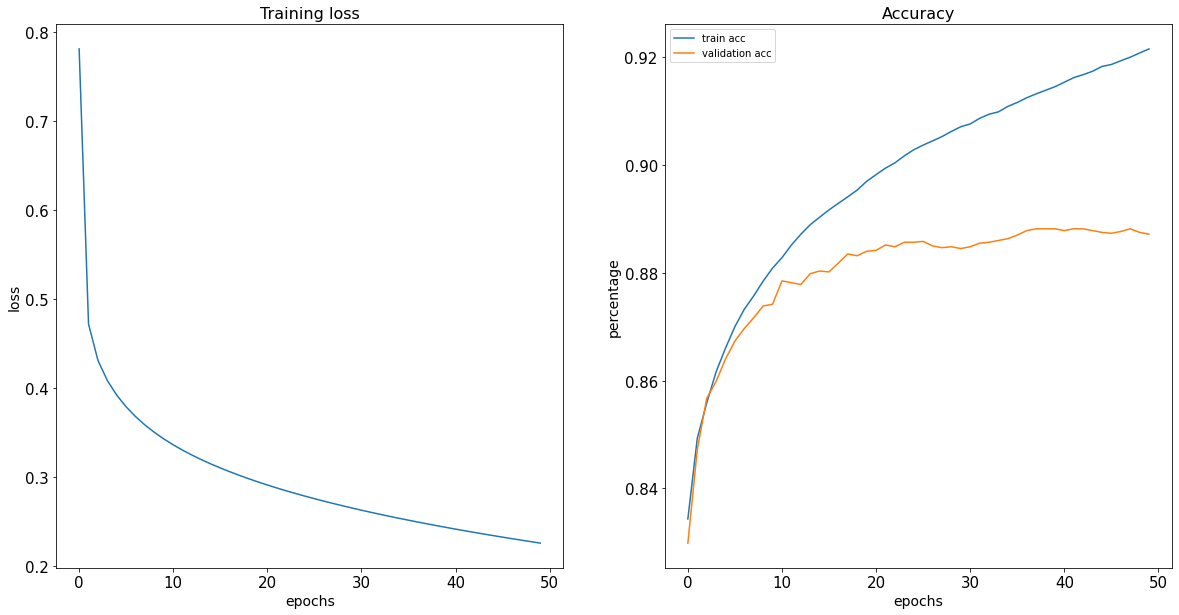

In [38]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))

ax[0].plot(range(50), base_loss)
ax[0].set_xlabel('epochs', size = 14)
ax[0].set_ylabel('loss', size = 14)
ax[0].set_title('Training loss', size = 16)

ax[1].plot(range(50), base_train_acc, label = 'train acc')
ax[1].plot(range(50), base_val_acc, label = 'validation acc')
ax[1].set_xlabel('epochs', size = 14)
ax[1].set_ylabel('percentage', size = 14)
ax[1].set_title('Accuracy', size = 16)
ax[1].legend()

for a in ax:
    a.tick_params(axis = 'both', labelsize = 15)

### Confusion Matrix

In [39]:
## Confusion matrix
def generate_confusion_mat(x, y, model):
    predictions_dict = {}
    labels_dict = {i: np.where(y[:, i] == 1)[0] for i in range(10)}
    for i in range(10):
        logits = model.forward(x[labels_dict[i]])
        predictions_dict[i] = np.argmax(logits, axis = 1)
        # One hot encode labels
        predictions_dict[i] = _one_hot(predictions_dict[i], 10)
        #print(predictions_dict[i].shape)
        predictions_dict[i] = np.sum(predictions_dict[i], axis = 0).astype(int)
        
    return predictions_dict

In [40]:
confusion_dict = generate_confusion_mat(x_train, y_train, baseline)

In [41]:
confusion_matrix = pd.DataFrame(confusion_dict)
confusion_matrix.rename_axis('predicted', axis = 0, inplace = True)
confusion_matrix.rename_axis('actual', axis = 1, inplace = True)
confusion_matrix

actual,0,1,2,3,4,5,6,7,8,9
predicted,,,,,,,,,,
0,4731,7,58,77,9,0,582,0,15,1
1,5,5370,1,30,4,1,8,0,1,0
2,87,4,4640,26,266,1,335,0,14,0
3,95,47,35,5043,112,1,81,0,14,0
4,10,4,377,147,4793,0,264,0,13,0
5,1,0,2,1,0,5312,0,21,2,16
6,455,7,305,62,206,2,4088,0,27,0
7,0,0,0,0,0,60,0,5273,5,123
8,28,2,16,10,8,3,37,4,5260,1


In [42]:
precision = confusion_matrix.apply(lambda x: x[x.name]/np.sum(x))
recall = confusion_matrix.apply(lambda x: x[x.name]/np.sum(x), axis = 1)
f1_score = (2*precision*recall)/(precision + recall)
support = confusion_matrix.apply(lambda x: np.sum(x), axis = 0)

classification_report = pd.concat([precision, recall, f1_score, support], axis = 1)
classification_report.columns = ['precision', 'recall','f1_score','support']
classification_report.round(4)

,precision,recall,f1_score,support
0,0.8740,0.8633,0.8686,5413
1,0.9870,0.9908,0.9889,5441
2,0.8539,0.8636,0.8587,5434
3,0.9344,0.9291,0.9317,5397
4,0.8879,0.8547,0.8710,5398
5,0.9857,0.9920,0.9888,5389
6,0.7576,0.7935,0.7751,5396
7,0.9790,0.9656,0.9723,5386
8,0.9830,0.9797,0.9813,5351
9,0.9739,0.9813,0.9776,5395


## Hparam Tuning

### Dropout

In [60]:
dropout_percs = np.linspace(0.01, 0.5, 10)
dropout_record = []
dropout_time = []
dropout_epochs = []

# Dropout in first 2 layers
for i in dropout_percs:
    print(i)
    dropouts_list = [None, 0, 0, 0, 0]
    dropouts_list[1] = i
    dropouts_list[2] = i
    
    nn = MLP(layers = [128,64,32,16,10],
             activation = [None,'tanh','tanh','relu','softmax'],
             batch_norm= [None, False, False, False, False],
             dropouts= dropouts_list)
    
    start = time.time()
    losses, train_acc, val_acc = nn.fit(X_train= x_train, Y_train=y_train, 
                                        X_val = x_val, Y_val = y_val, 
                                        epochs = 20,batch_size = 128,learning_rate= 0.01,
                                        optimizer = 'adam', verbose= False)
    
    end = time.time()
    dropout_time.append(end - start)
    dropout_record.append(val_acc[-1])
    dropout_epochs.append(len(val_acc))

0.01
0.06444444444444444
0.11888888888888888
0.17333333333333334
0.22777777777777777
0.2822222222222222
0.33666666666666667
0.3911111111111111
0.44555555555555554
0.5


In [63]:
dropout_df = pd.DataFrame({'Dropout': dropout_percs, 'Val accuracy': dropout_record,
                           'time (s)': dropout_time,'optimal epochs': dropout_epochs})

dropout_df.sort_values('Val accuracy', ascending = False).round(4)

,Dropout,Val accuracy,time (s),optimal epochs
7,0.3911,0.8777,34.4246,20
3,0.1733,0.8768,33.3630,20
6,0.3367,0.8758,32.2731,20
0,0.0100,0.8732,28.4298,20
4,0.2278,0.8725,29.9957,20
5,0.2822,0.8722,29.1063,20
1,0.0644,0.8718,32.7733,20
9,0.5000,0.8718,32.1479,20
2,0.1189,0.8713,33.6318,20
8,0.4456,0.8700,34.4588,20


### Beta1 (Adam)

In [64]:
beta1_list = np.linspace(0.5, 0.9, 10)
beta1_record = []
beta1_time = []
beta1_epochs = []

for b in beta1_list:
    print(b)
    nn = MLP(layers = [128,64,32,16,10],
             activation = [None,'tanh','tanh','relu','softmax'],
             batch_norm= [None, False, False, False, False],
             dropouts= [None, 0, 0, 0, 0])
    start = time.time()
    losses, train_acc, val_acc = nn.fit(X_train= x_train, Y_train=y_train, 
                                        X_val = x_val, Y_val = y_val, 
                                        epochs = 20,batch_size = 128, learning_rate= 0.01,
                                        beta1 = b,
                                        optimizer = 'adam', verbose= False)
    
    end = time.time()
    beta1_time.append(end - start)
    beta1_record.append(val_acc[-1])
    beta1_epochs.append(len(val_acc))

0.5
0.5444444444444444
0.5888888888888889
0.6333333333333333
0.6777777777777778
0.7222222222222222
0.7666666666666666
0.8111111111111111
0.8555555555555556
0.9


In [66]:
beta_df = pd.DataFrame({'betas': beta1_list, 'Val accuracy': beta1_record,
                        'time (s)': beta1_time, 'optimal epochs': beta1_epochs})

beta_df.sort_values('Val accuracy', ascending = False).round(4)

,betas,Val accuracy,time (s),optimal epochs
0,0.5000,0.8910,36.4605,20
2,0.5889,0.8870,36.1799,20
4,0.6778,0.8867,32.3825,20
1,0.5444,0.8858,33.4271,20
3,0.6333,0.8858,34.4735,20
5,0.7222,0.8852,34.4209,20
7,0.8111,0.8840,32.3539,20
6,0.7667,0.8838,37.9875,20
8,0.8556,0.8778,33.8024,20
9,0.9000,0.8680,32.9444,20


### Weight Decay

In [67]:
decay_list = np.linspace(0, 0.5, 10)
decay_record = []
decay_time = []
decay_epochs = []

for d in decay_list:
    print(d)
    nn = MLP(layers = [128,64,32,16,10],
             activation = [None,'tanh','tanh','relu','softmax'],
             batch_norm= [None, False, False, False, False],
             dropouts= [None, 0, 0, 0, 0])
    
    start = time.time()
    losses, train_acc, val_acc = nn.fit(X_train= x_train, Y_train=y_train, 
                                        X_val = x_val, Y_val = y_val, 
                                        epochs = 20,batch_size = 128, learning_rate= 0.01,
                                        weight_decay = d,
                                        optimizer = 'adam', verbose= False)
    
    end = time.time()
    decay_time.append(end - start)
    decay_record.append(val_acc[-1])
    decay_epochs.append(len(val_acc))

0.0
0.05555555555555555
0.1111111111111111
0.16666666666666666
0.2222222222222222
0.2777777777777778
0.3333333333333333
0.38888888888888884
0.4444444444444444
0.5


In [69]:
decay_df = pd.DataFrame({'decays': decay_list, 'Val accuracy': decay_record,
                         'time (s)': decay_time,'optimal epochs': decay_epochs})

decay_df.sort_values('Val accuracy', ascending = False).round(4)

,decays,Val accuracy,time (s),optimal epochs
0,0.0000,0.8743,30.5239,20
1,0.0556,0.1948,28.8135,20
2,0.1111,0.1007,44.4545,20
3,0.1667,0.1007,48.7856,20
4,0.2222,0.1007,43.1952,20
5,0.2778,0.1007,41.7992,20
6,0.3333,0.1007,45.3039,20
7,0.3889,0.1007,48.2214,20
8,0.4444,0.1007,49.5604,20
9,0.5000,0.1007,46.7139,20


### Batch Size

In [29]:
batch_list = [24, 64, 128, 256, 512,1024]
batch_record = []
batch_time = []
batch_epochs = []

for b in batch_list:
    print(b)
    nn = MLP(layers = [128,64,32,16,10],
             activation = [None,'tanh','tanh','relu','softmax'],
             batch_norm= [None, False, False, False, False],
             dropouts= [None, 0, 0, 0, 0])
    
    start = time.time()
    losses, train_acc, val_acc = nn.fit(X_train= x_train, Y_train=y_train, 
                                        X_val = x_val, Y_val = y_val, 
                                        epochs = 20,batch_size = b, 
                                        learning_rate= 0.01,optimizer = 'adam', verbose= False)
    
    end = time.time()
    batch_time.append(end - start)
    batch_record.append(val_acc[-1])
    batch_epochs.append(len(val_acc))

24
64
128
256
512
1024


In [70]:
batchsize_df = pd.DataFrame({'batch_sizes': batch_list, 'Val accuracy': batch_record,
                             'time (s)': batch_time,'optimal epochs': batch_epochs})

batchsize_df.sort_values('Val accuracy', ascending = False).round(4)

,batch_sizes,Val accuracy,time (s),optimal epochs
1,64,0.8757,43.2435,20
3,256,0.8753,29.3801,20
5,1024,0.8745,22.6388,20
4,512,0.8733,23.2913,20
2,128,0.8718,31.8110,20
0,24,0.8638,58.6757,20


### Batch Norm

In [71]:
bn_choice = [True, False]
bn_record = []
bn_time = []
bn_epochs = []

for i in bn_choice:
    print(i)
    bn_list = [None, False, False, False, False]
    bn_list[1] = i
    
    nn = MLP(layers = [128,64,32,16,10],
             activation = [None,'tanh','tanh','relu','softmax'],
             batch_norm= bn_list, dropouts= [None, 0, 0, 0, 0])
    
    start = time.time()
    losses, train_acc, val_acc = nn.fit(X_train= x_train, Y_train=y_train, 
                                        X_val = x_val, Y_val = y_val, 
                                        epochs = 20,batch_size = 128, learning_rate= 0.01,
                                        optimizer = 'adam', verbose= False)
    
    end = time.time()
    bn_time.append(end - start)
    bn_record.append(val_acc[-1])
    bn_epochs.append(len(val_acc))

True
False


In [72]:
batchnorm_df = pd.DataFrame({'BN': bn_choice, 'Val accuracy': bn_record,
                             'time (s)': bn_time,'optimal epochs': bn_epochs})

batchnorm_df.sort_values('Val accuracy', ascending = False).round(4)

,BN,Val accuracy,time (s),optimal epochs
1,False,0.8712,27.2886,20
0,True,0.8647,29.7422,20


## Comparing optimal models

In [73]:
# Dropout = 0.3911

nn_1 = MLP(layers = [128,64,32,16,10],
           activation = [None,'tanh','tanh','relu','softmax'],
           batch_norm= [None, False, False, False, False],
           dropouts= [None, 0.3911, 0.3911, 0,0])

_, _, vacc_1 = nn_1.fit(X_train= x_train, Y_train=y_train, 
                      X_val = x_val, Y_val = y_val, 
                      epochs = 20,batch_size = 128,learning_rate= 0.01,
                      optimizer = 'adam', verbose= False)

In [89]:
# beta1 = 0.5
nn_2 = MLP(layers = [128,64,32,16,10],
           activation = [None,'tanh','tanh','relu','softmax'],
           batch_norm= [None, False, False, False, False],
           dropouts= [None, 0, 0, 0, 0])

_, _, vacc_2 = nn_2.fit(X_train= x_train, Y_train=y_train, 
                      X_val = x_val, Y_val = y_val, 
                      epochs = 20,batch_size = 128, learning_rate= 0.01,
                      beta1 = 0.5,
                      optimizer = 'adam', verbose= False)

In [75]:
# Batch size = 64
nn_3 = MLP(layers = [128,64,32,16,10],
           activation = [None,'tanh','tanh','relu','softmax'],
           batch_norm= [None, False, False, False, False],
           dropouts= [None, 0, 0, 0, 0])

_, _, vacc_3 = nn_3.fit(X_train= x_train, Y_train=y_train, 
                      X_val = x_val, Y_val = y_val, 
                      epochs = 20,batch_size = 64, learning_rate= 0.01,
                      optimizer = 'adam', verbose= False)

In [76]:
# Batchnorm = True
nn_4 = MLP(layers = [128,64,32,16,10],
           activation = [None,'tanh','tanh','relu','softmax'],
           batch_norm= [None, True, False, False, False],
           dropouts= [None, 0, 0, 0, 0])

_, _, vacc_4 = nn.fit(X_train= x_train, Y_train=y_train, 
                      X_val = x_val, Y_val = y_val, 
                      epochs = 20,batch_size = 128, learning_rate= 0.01,
                      optimizer = 'adam', verbose= False)

In [87]:
# Tensorflow
nn_tf = MLP(layers = [128,32,32,16,10],
           activation = [None,'tanh','tanh','relu','softmax'],
           batch_norm= [None, False, False, False, False],
           dropouts= [None, 0.015, 0, 0, 0])

_, _, vacc_tf = nn.fit(X_train= x_train, Y_train=y_train, 
                      X_val = x_val, Y_val = y_val, 
                      epochs = 20,batch_size = 1024, learning_rate= 0.01,
                      beta1 = 0.6376, optimizer = 'adam', verbose= False)

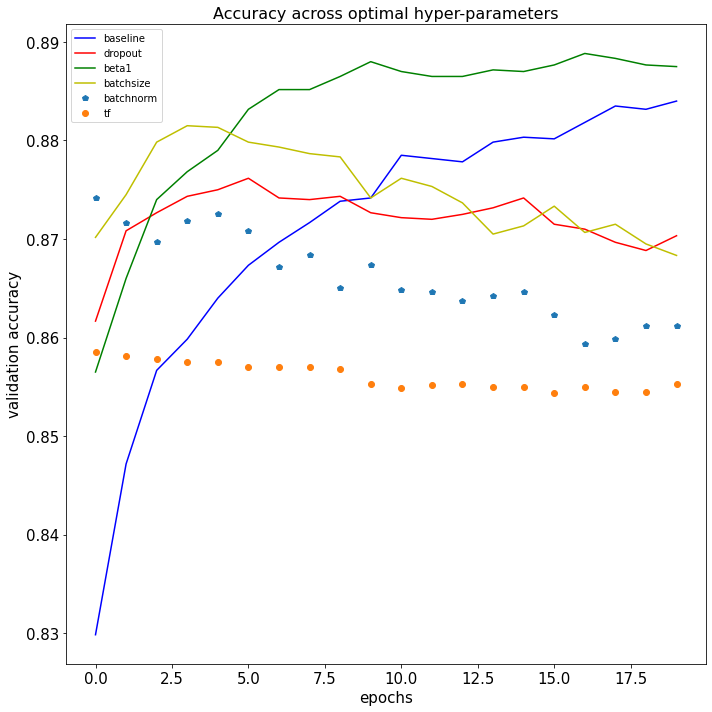

In [90]:
plt.figure(figsize = (10, 10))
for col, value, name in zip(['b', 'r', 'g', 'y', 'p', 'o'], 
                            [base_val_acc[:20], vacc_1, vacc_2, vacc_3, vacc_4, vacc_tf],
                            ['baseline', 'dropout', 'beta1', 'batchsize', 'batchnorm', 'tf']):
    
    plt.plot(value, col, label = name)
    plt.xlabel('epochs', size = 15)
    plt.ylabel('validation accuracy', size = 15)
    plt.title('Accuracy across optimal hyper-parameters', size = 16)
    plt.tick_params(axis = 'both', labelsize = 15)
    plt.legend()
    plt.tight_layout()

## Spare parts

### Learning rate

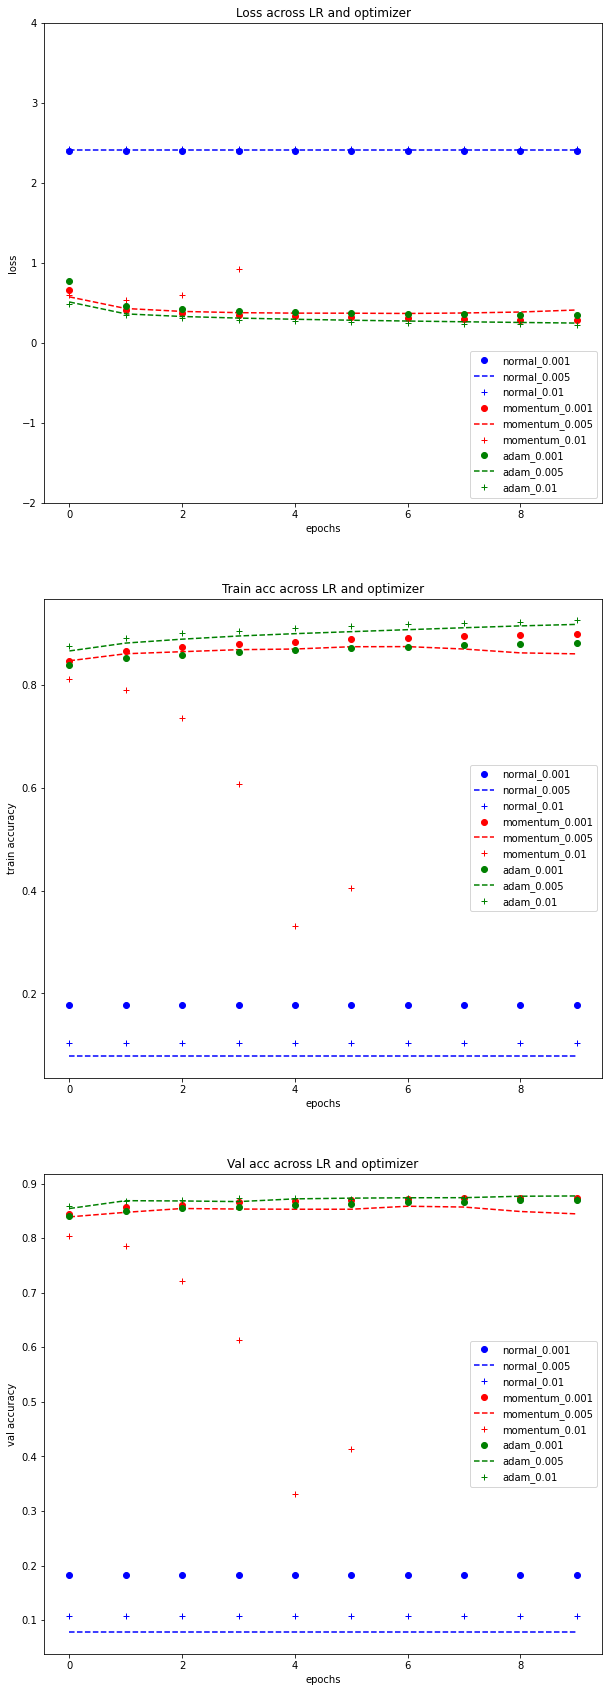

In [149]:
fig, ax = plt.subplots(3, 1, figsize = (10, 30))

for col, optimizer in zip(['b', 'r', 'g'], ['normal', 'momentum','adam']):
    for pattern, lr in zip(['o', '--', '+'], [0.001, 0.005, 0.01]):
        nn = MLP(layers = [128,64,32,16,10],
                 activation = [None,'tanh','tanh','relu','softmax'],
                 batch_norm= [None, False, False, False, False],
                 dropouts= [None, 0, 0, 0, 0])
        
        losses, train_acc, val_acc = nn.fit(X_train= x_train, Y_train=y_train,X_val = x_val, Y_val = y_val, 
                                            epochs = 10,batch_size = 128,learning_rate= lr,
                                            optimizer = optimizer, verbose= False)
        
        #print(losses)
        loss_modified = np.nan_to_num(losses, nan = -2)
        train_acc_modified = np.nan_to_num(train_acc, nan = 0)
        val_acc_modified = np.nan_to_num(val_acc, nan = 0)
        
        ax[0].plot(loss_modified, col+pattern, label = '{}_{}'.format(optimizer, lr))
        ax[0].set_ylim(-2, 4)
        ax[0].set_title('Loss across LR and optimizer')
        ax[0].set_xlabel('epochs')
        ax[0].set_ylabel('loss')
        ax[0].legend(loc = 'lower right')
        
        ax[1].plot(train_acc_modified, col+pattern, label = '{}_{}'.format(optimizer, lr))
        ax[1].set_title('Train acc across LR and optimizer')
        ax[1].set_xlabel('epochs')
        ax[1].set_ylabel('train accuracy')
        ax[1].legend()
        
        ax[2].plot(val_acc_modified, col+pattern, label = '{}_{}'.format(optimizer, lr))
        ax[2].set_title('Val acc across LR and optimizer')
        ax[2].set_xlabel('epochs')
        ax[2].set_ylabel('val accuracy')
        ax[2].legend()
        

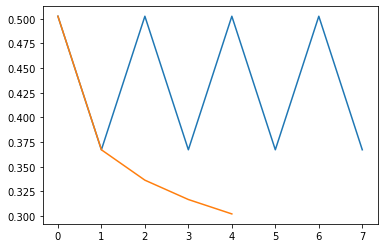

In [42]:
plt.plot(losses[:2]*4)
plt.plot(losses)

### Reg - Batch norm

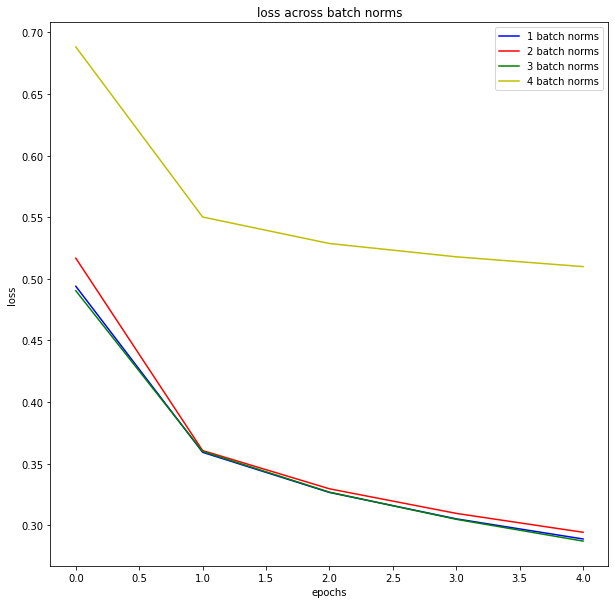

In [55]:
plt.figure(figsize= (10,10))
for col, i in zip(['b', 'r', 'g', 'y'], range(1, 5)):
    batch_norm_list = [None, False, False, False, False]
    batch_norm_list[i] = True
    
    nn = MLP(layers = [128,64,32,16,10],
             activation = [None,'tanh','tanh','relu','softmax'],
             batch_norm= batch_norm_list,
             dropouts= [None, 0, 0, 0, 0])
    
    losses, train_acc, val_acc = nn.fit(X_train= x_train, Y_train=y_train, 
                                        X_val = x_val, Y_val = y_val, 
                                        epochs = 5,batch_size = 128, learning_rate= 0.01,
                                        optimizer = 'adam', verbose= False)
    
    plt.plot(losses, col, label = '{} batch norms'.format(i))
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('loss across batch norms')
    plt.legend()

### Weight Decay

In [109]:
?plt.legend

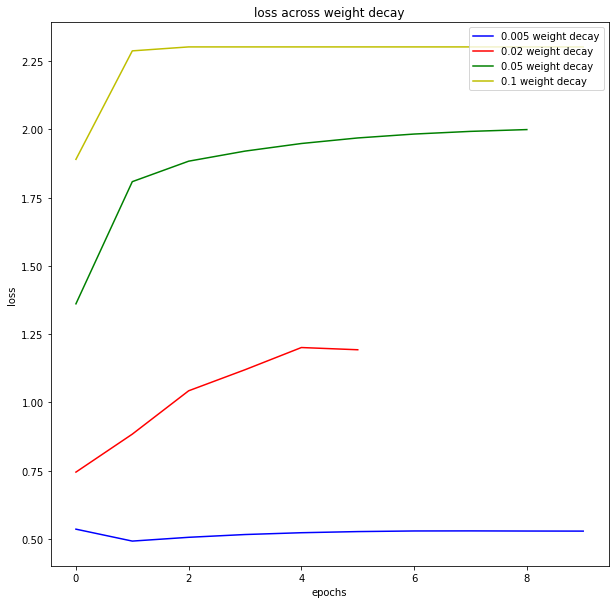

In [110]:
plt.figure(figsize= (10,10))

for col, i in zip(['b', 'r', 'g', 'y'], [0.005, 0.02, 0.05, 0.1]):
    nn = MLP(layers = [128,64,32,16,10],
             activation = [None,'tanh','tanh','relu','softmax'],
             batch_norm= [None, False, False, False, False],
             dropouts= [None, 0, 0, 0, 0])
    
    losses, train_acc, val_acc = nn.fit(X_train= x_train, Y_train=y_train, 
                                        X_val = x_val, Y_val = y_val, 
                                        epochs = 10,batch_size = 128, learning_rate= 0.01,
                                        weight_decay = i,
                                        optimizer = 'adam', verbose= False)
    
    plt.plot(losses, col, label = '{} weight decay'.format(i))
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('loss across weight decay')
    plt.legend(loc = 'upper right')

### Dropout

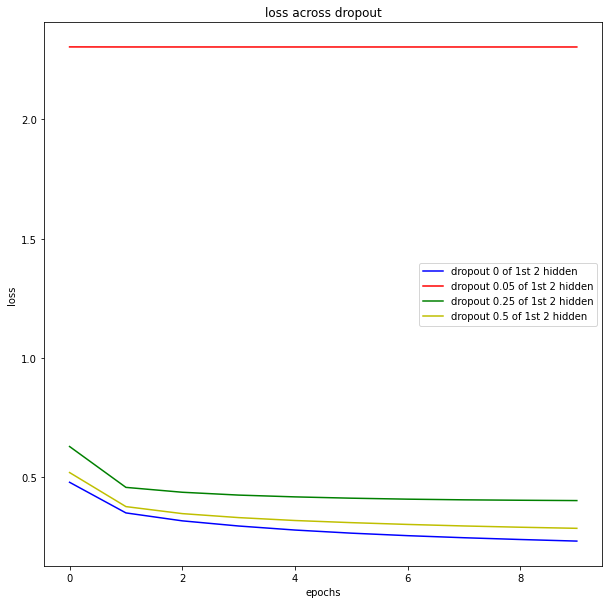

In [62]:
plt.figure(figsize= (10,10))
for col, i in zip(['b', 'r', 'g', 'y'], [0, 0.05, 0.25, 0.5]):
    
    dropouts_list = [None, 0, 0, 0, 0]
    dropouts_list[1] = i
    dropouts_list[2] = i
    
    nn = MLP(layers = [128,64,32,16,10],
             activation = [None,'tanh','tanh','relu','softmax'],
             batch_norm= [None, False, False, False, False],
             dropouts= dropouts_list)
    
    losses, train_acc, val_acc = nn.fit(X_train= x_train, Y_train=y_train, 
                                        X_val = x_val, Y_val = y_val, 
                                        epochs = 10,batch_size = 128, learning_rate= 0.01,
                                        optimizer = 'adam', verbose= False)
    
    plt.plot(losses, col, label = 'dropout {} of 1st 2 hidden'.format(i))
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('loss across dropout')
    plt.legend()

In [74]:
np.random.binomial(1, 0.05, size = (1, 5))

array([[0, 1, 1, 0, 0]])